In [104]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import sklearn.preprocessing 
import sklearn.linear_model
import sklearn.model_selection
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#delete future ish. cahgne ignore to default if you want to revert 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [21]:
#loading data
data_path = 'train.csv'
df = pd.read_csv(data_path, index_col=0)

#replace all na's with empty string in text columns, replace with 0 in data columns
def na_fixer(df):
    for column in df.columns:
        if df.dtypes[column]==object:
            df[column].fillna("",inplace=True)
        else: df[column].fillna(0,inplace=True)
na_fixer(df)

In [6]:
#returns stats if numerical, returns value counts if string 
def describer(df):
    for column in df.columns:
        print(column)
        if df.dtypes[column] == object:
            print (df[column].value_counts())
        else: print(df[column].describe())
        print('\n')

In [22]:
#uses feature encoding with SKLEARN to turn all object.type entries into numerical values. plots a heatmap of the correlation between the features and sale price 
def encoder(df):
    result = df.copy()
    encoders = {}
    l_e = sklearn.preprocessing.LabelEncoder()
    for column in result.columns:
            if result.dtypes[column] == object:
                encoders[column] = l_e.fit(result[column])
                result[column] = encoders[column].fit_transform(result[column])
    return result, encoders
#encoding
df_enc, _= encoder(df)
df_sp = df_enc['SalePrice']

In [ ]:
#heatmap plot
plt.figure(figsize = (50,50))
sns.heatmap(df_enc.corr(), square = True, annot=True, cmap="RdYlGn")

In [126]:
#splitting our encoded dataset into test data and training data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_enc[df_enc.columns.drop('SalePrice')], df_sp, train_size=0.8)

In [14]:
#standard normal scaling for all encoded features 
scaler = sklearn.preprocessing.StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_sc = scaler.fit_transform(X_test)

In [75]:
#using skl KBest to get initial inference around most important features. Note this needs nonnegative values. Can't use normally scaled values  
selectbest = SelectKBest(score_func=chi2, k=15)
fit = selectbest.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_, columns=['Scores'])
X_train_cols = pd.DataFrame(X_train.columns,  columns=['Feature'])
feature_scores = pd.concat([dfscores,X_train_cols],axis=1)
features_Kbest=list(feature_scores.sort_values(by = 'Scores',ascending=False).head(15)['Feature'])

[0.01578467 0.00954503 0.02920376 0.02961222 0.00043856 0.00378584
 0.01578993 0.00686626 0.00017224 0.01422848 0.00288071 0.02270777
 0.00809835 0.0006208  0.00636759 0.01461959 0.01757294 0.01478985
 0.02775391 0.02413031 0.01321653 0.00103322 0.01730708 0.01935804
 0.01435859 0.01699695 0.00798167 0.00720206 0.01049283 0.01198423
 0.00556144 0.01670889 0.02034919 0.02431203 0.00825405 0.0066655
 0.02902312 0.02728542 0.00138428 0.01588443 0.00373004 0.00557803
 0.02749465 0.01802577 0.00125618 0.02802931 0.01420865 0.00486322
 0.01094262 0.01012877 0.01730469 0.00193638 0.01196029 0.02342131
 0.00409249 0.01062098 0.01216796 0.01170356 0.02191039 0.01591706
 0.01400964 0.02823034 0.00400496 0.00325338 0.00444049 0.02124534
 0.02171495 0.0100391  0.00156379 0.0058074  0.00042954 0.0001742
 0.01186502 0.00305463 0.00168797 0.02966187 0.02400205 0.00888132
 0.01031327]


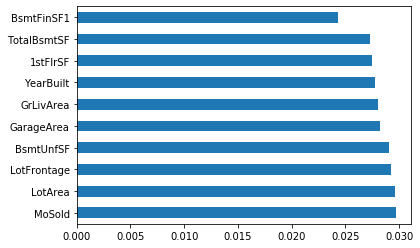

In [59]:
#using tree classifier to generate most important features
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_sc,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [39]:
#OLS regressiont to understand best parameters
#Adding constant column of ones, mandatory for sm.OLS model
X_test_1 = sm.add_constant(X_test)
#Fitting sm.OLS model
model = sm.OLS(y_test,X_test_1).fit()
model.pvalues
#this returns pvalues for our model, where the null hypothesis is that a coefficient is equal to zero. a pvalue <0.05 indicates we can reject the null and say that the coefficient is NOT equal to zero. 

const            0.830199
MSSubClass       0.795578
MSZoning         0.054970
LotFrontage      0.000035
LotArea          0.015405
Street           0.010587
Alley            0.266683
LotShape         0.065906
LandContour      0.056999
Utilities        0.013647
LotConfig        0.223645
LandSlope        0.258615
Neighborhood     0.843030
Condition1       0.881522
Condition2       0.332546
BldgType         0.562524
HouseStyle       0.590997
OverallQual      0.004981
OverallCond      0.000047
YearBuilt        0.037030
YearRemodAdd     0.136159
RoofStyle        0.754770
RoofMatl         0.002527
Exterior1st      0.675917
Exterior2nd      0.952840
MasVnrType       0.083796
MasVnrArea       0.001265
ExterQual        0.023662
ExterCond        0.322248
Foundation       0.952570
BsmtQual         0.023550
BsmtCond         0.080536
BsmtExposure     0.167701
BsmtFinType1     0.478513
BsmtFinSF1       0.058477
BsmtFinType2     0.733268
BsmtFinSF2       0.684234
BsmtUnfSF        0.883920
TotalBsmtSF 

In [94]:
#backwards elimination using above approach. Note we take values[1:] because we are ignoring the constant.. 
cols = list(X_test.columns)
pmax = 1

def OLS_features(X,y,pvalue=0.025):
    while (len(cols) > 0):
        p = []
        X_test_1 = X[cols]
        X_test_1 = sm.add_constant(X_test_1)
        model = sm.OLS(y,X_test_1).fit()
        p = pd.Series(model.pvalues.values[1:],index=cols)
        pmax= max(p)
        feature_with_max_p=p.idxmax()
        if (pmax>pvalue):
            cols.remove(feature_with_max_p)
        else:
            break
    features_OLS=cols
    return features_OLS
OLS_features(X_test,y_test)

['LotFrontage',
 'LotArea',
 'Street',
 'LotShape',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'RoofMatl',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'BsmtFinSF1',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'GarageArea',
 'WoodDeckSF',
 'SaleCondition']

In [98]:
features_OLS=OLS_features(X_train,y_train)

In [101]:
OLS=set(features_OLS)
Kbest=set(features_Kbest)

Union=OLS.intersection(Kbest)

In [ ]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

In [119]:
#now running RFE for feature selection
# model_rfe = LinearRegression()
# rfe = RFE(model_rfe,15) 
# X_train_rfe = rfe.fit_transform(X_train,y_train)
# model_rfe.fit(X_train_rfe,y_train)

# print(rfe.support_)
# print(rfe.ranking_)

[False False False False  True False False False  True False  True False
 False False False False  True False False False False  True False False
 False False  True False False False False False False False False False
 False False False False False False False False False False  True  True
  True False False  True  True  True False  True False False False False
  True False False False False False False False False False False  True
 False False False False False False False]
[43 19 48 64  1 30 17 14  1 37  1 34 27  7  4 16  1 11 39 50  6  1 24 35
 40 47  1 31 36  2  3 15 21 57 22 56 60 52 13 41 51 26 42 45 53 58  1  1
  1  8 20  1  1  1 12  1  9 28 61 10  1 62 18 32  5 55 63 59 54 46 29  1
 44 49 65 38 23 33 25]


In [144]:
#now estimating the optimum number of features 
high_score=0
nof_list=np.arange(1,80)
#variable to store optimal features
nof=0
score_list=[]
model_rfe=LinearRegression()

#we are now saying rfe is model with number of features going up to 80 gradually loop by loop, then we store the accuracies
for n in range(len(nof_list)):
    rfe=RFE(model_rfe,nof_list[n])
    X_train_rfe=rfe.fit_transform(X_train,y_train)
    X_test_rfe=rfe.transform(X_test)
    model_rfe.fit(X_train_rfe,y_train)
    score = model_rfe.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print([score_list])

Optimum number of features: 79
Score with 79 features: 0.863349
[[0.6336066094045196, 0.6406394999056959, 0.655912569794131, 0.6722870079833212, 0.6721426290788357, 0.6971432820602641, 0.7177529935881917, 0.7177701912661738, 0.7383248951934878, 0.7480312980939274, 0.7486504803590388, 0.7477330987763156, 0.7478825192213743, 0.7814057482129727, 0.7835626979076076, 0.7842231941861502, 0.7816999543408807, 0.7879809477320574, 0.7869933310147279, 0.7866001209770246, 0.7872995224602696, 0.7895432576353889, 0.7963398851124124, 0.795823441539044, 0.7991142265916149, 0.7988484819312769, 0.8015747160757667, 0.8005343107358536, 0.8006707212504252, 0.8015286469011238, 0.8033096996661453, 0.8070914617412508, 0.8075470496038097, 0.8110221151954302, 0.8128838576038904, 0.813135664343369, 0.8144780936737365, 0.8154019737854585, 0.8151982755552342, 0.8147973714229692, 0.8160096144534084, 0.815779580970316, 0.8159229475519252, 0.8161760128409186, 0.8158957708895583, 0.814346460678017, 0.813774348780901, 